**Advanced Astroinformatics (Semester 1 2025)**
# Discussing Results so far

**Advanced Astroinformatics Student Project**

*N. Hernitschek*



---
## Contents
* [Recap, Questions](#first-bullet)
* [Tasks for Today](#second-bullet)
* [Summary](#fifth-bullet)


## 1. Recap, Questions <a class="anchor" id="first-bullet"></a>

Time for questions!

Your **tasks until this week** were:


Create a feature table showing the calculated features for all variable stars in the TESS sample (using the _TESS_lightcurves_outliercleaned light curves).

Use this feature table to create a triangle plot showing the features first for all variable stars from one star type (e.g.: ACV). If this works, for each type create a triangle plot.
Then, calculate the feature table also for the other versions of the light curves (_TESS_lightcurves_median_after_detrended, _TESS_lightcurves_raw). Overplot these features to each of your triangle plots. (I.e.: After this step you should have individual triangle plots for the types ACV, CEP, DCEP..., showing the calculated features for te raw, median/detrended, and outlier cleaned light curves.)

What do these triangle plots tell you?

Did you find certain patterns, regions... in the plots that correspond to what you have read about variable stars (https://www.aavso.org/vsx/index.php?view=about.vartypes)?

If already done: Which distinctive differences do you recognize between plots done from the three different versions of the light curve (_TESS_lightcurves_outliercleaned, _TESS_lightcurves_median_after_detrended, _TESS_lightcurves_raw)?

## 2. Tasks for Today <a class="anchor" id="second-bullet"></a>

If not already done: Repeat the light curve plots, feature table and triangle plots for all the other versions of the light curves (_TESS_lightcurves_median_after_detrended, _TESS_lightcurves_raw).

Otherwise: Take a look at https://scikit-learn.org/stable/tutorial/basic/tutorial.html and try to familiarize yourself with `scikit-learn`.

You can also take a look at https://www.overleaf.com/. This is an online LaTeX editor. It is widely used in astronomy for writing papers collaboratively. I thus recommend using it for your project report.

Today we are doing (again) a coding and Q&A session today and continue next week with a detailed introduction to machine learning and `scikit-learn`.

In [1]:
#The set of functions in this file for the light curves (because importing them via a .py file is a pain)
import math

import warnings

import numpy as np

from scipy import stats
from statsmodels.tsa import stattools
from scipy.interpolate import interp1d
from scipy.stats import chi2


def Amplitude(mag):
    
        n = len(mag)
        sorted_mag = np.sort(mag)

        return (np.median(sorted_mag[int(-math.ceil(0.05 * n)):]) -
                np.median(sorted_mag[0:int(math.ceil(0.05 * n))])) / 2.0


def Rcs(mag):
        """Range of cumulative sum"""
        sigma = np.std(mag)
        N = len(mag)
        m = np.mean(mag)
        s = np.cumsum(mag - m) * 1.0 / (N * sigma)
        R = np.max(s) - np.min(s)
        return R


def StetsonK(mag,magerr):
        n = len(mag)

        mean_mag = (np.sum(mag/(magerr*magerr))/np.sum(1.0 / (magerr * magerr)))
        sigmap = (np.sqrt(n * 1.0 / (n - 1)) *
                  (mag - mean_mag) / magerr)

        k = (1 / np.sqrt(n * 1.0) * np.sum(np.abs(sigmap)) / np.sqrt(np.sum(sigmap ** 2)))
        return k


def Meanvariance(mag):
  
        return np.std(mag) / np.mean(mag)


def Autocor_length(mag):
    
        nlags=100
        ac = stattools.acf(mag, nlags=nlags, fft=False)

        k = next((index for index, value in
                 enumerate(ac) if value < np.exp(-1)), None)

        while k is None:
            if nlags > len(mag):
                warnings.warn('Setting autocorrelation length as light curve length')
                return len(mag)
            nlags = nlags + 100
            ac = stattools.acf(mag, nlags=nlags, fft=False)
            k = next((index for index, value in
                      enumerate(ac) if value < np.exp(-1)), None)

        return k



def Con(mag):
    """Index introduced for selection of variable stars from OGLE database.

    To calculate Con, we count the number of three consecutive measurements
    that are out of 2-sigma range, and normalize by N-2.
    """
    consecutiveStar = 3
    N = len(mag)
    if N < consecutiveStar:
        return 0
    sigma = np.std(mag)
    m = np.mean(mag)
    count = 0

    for i in range(N - consecutiveStar + 1):
        flag = 0
        for j in range(consecutiveStar):
            if (mag[i + j] > m + 2 * sigma or mag[i + j] < m - 2 * sigma):
                flag = 1
            else:
                flag = 0
                break
        if flag:
            count += 1

    return count * 1.0 / (N - consecutiveStar + 1)



def Beyond1Std(mag,magerr):
        """Percentage of points beyond one st. dev. from the weighted
        (by photometric errors) mean
        """

        n = len(mag)

        weighted_mean = np.average(mag, weights=1 / magerr ** 2)

        # Standard deviation with respect to the weighted mean
        var = sum((mag - weighted_mean) ** 2)
        std = np.sqrt((1.0 / (n - 1)) * var)

        count = np.sum(np.logical_or(mag > weighted_mean + std,
                                     mag < weighted_mean - std))
        return float(count) / n


def SmallKurtosis(mag):
        """Small sample kurtosis of the magnitudes.

        See http://www.xycoon.com/peakedness_small_sample_test_1.htm
        """
    
        n = len(mag)
        mean = np.mean(mag)
        std = np.std(mag)

        S = sum(((mag - mean) / std) ** 4)

        c1 = float(n * (n + 1)) / ((n - 1) * (n - 2) * (n - 3))
        c2 = float(3 * (n - 1) ** 2) / ((n - 2) * (n - 3))

        return c1 * S - c2


def Std(mag):
        """Standard deviation of the magnitudes"""

        return np.std(mag)


def Skew(mag):
        """Skewness of the magnitudes"""
        return stats.skew(mag)


def MaxSlope(mag,time):
        """
        Examining successive (time-sorted) magnitudes, the maximal first difference
        (value of delta magnitude over delta time)
        """
  

        slope = np.abs(mag[1:] - mag[:-1]) / (time[1:] - time[:-1])
        np.max(slope)

        return np.max(slope)


def MedianAbsDev(mag):
   

        median = np.median(mag)

        devs = (abs(mag - median))

        return np.median(devs)


def MedianBRP(mag):
        """Median buffer range percentage

        Fraction (<= 1) of photometric points within amplitude/10
        of the median magnitude
        """

        median = np.median(mag)
        amplitude = (np.max(mag) - np.min(mag)) / 10
        n = len(mag)

        count = np.sum(np.logical_and(mag < median + amplitude,
                                      mag > median - amplitude))

        return float(count) / n


def PairSlopeTrend(mag):
        """
        Considering the last 30 (time-sorted) measurements of source magnitude,
        the fraction of increasing first differences minus the fraction of
        decreasing first differences.
        """
  
        data_last = mag[-30:]

        return (float(len(np.where(np.diff(data_last) > 0)[0]) -
                len(np.where(np.diff(data_last) <= 0)[0])) / 30)


def FluxPercentileRatioMid20(mag):
  
        sorted_data = np.sort(mag)
        lc_length = len(sorted_data)

        F_60_index = math.ceil(0.60 * lc_length)
        F_40_index = math.ceil(0.40 * lc_length)
        F_5_index = math.ceil(0.05 * lc_length)
        F_95_index = math.ceil(0.95 * lc_length)

        F_40_60 = sorted_data[F_60_index] - sorted_data[F_40_index]
        F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]
        F_mid20 = F_40_60 / F_5_95

        return F_mid20


def FluxPercentileRatioMid35(mag):
   
        sorted_data = np.sort(mag)
        lc_length = len(sorted_data)

        F_325_index = math.ceil(0.325 * lc_length)
        F_675_index = math.ceil(0.675 * lc_length)
        F_5_index = math.ceil(0.05 * lc_length)
        F_95_index = math.ceil(0.95 * lc_length)

        F_325_675 = sorted_data[F_675_index] - sorted_data[F_325_index]
        F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]
        F_mid35 = F_325_675 / F_5_95

        return F_mid35


def FluxPercentileRatioMid50(mag):
   
        sorted_data = np.sort(mag)
        lc_length = len(sorted_data)

        F_25_index = math.ceil(0.25 * lc_length)
        F_75_index = math.ceil(0.75 * lc_length)
        F_5_index = math.ceil(0.05 * lc_length)
        F_95_index = math.ceil(0.95 * lc_length)

        F_25_75 = sorted_data[F_75_index] - sorted_data[F_25_index]
        F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]
        F_mid50 = F_25_75 / F_5_95

        return F_mid50


def FluxPercentileRatioMid65(mag):
 
        sorted_data = np.sort(mag)
        lc_length = len(sorted_data)

        F_175_index = math.ceil(0.175 * lc_length)
        F_825_index = math.ceil(0.825 * lc_length)
        F_5_index = math.ceil(0.05 * lc_length)
        F_95_index = math.ceil(0.95 * lc_length)

        F_175_825 = sorted_data[F_825_index] - sorted_data[F_175_index]
        F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]
        F_mid65 = F_175_825 / F_5_95

        return F_mid65


def FluxPercentileRatioMid80(mag):
  
        sorted_data = np.sort(mag)
        lc_length = len(sorted_data)

        F_10_index = math.ceil(0.10 * lc_length)
        F_90_index = math.ceil(0.90 * lc_length)
        F_5_index = math.ceil(0.05 * lc_length)
        F_95_index = math.floor(0.95 * lc_length)

        F_10_90 = sorted_data[F_90_index] - sorted_data[F_10_index]
        F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]
        F_mid80 = F_10_90 / F_5_95

        return F_mid80


def PercentDifferenceFluxPercentile(mag):
   
        median_data = np.median(mag)

        sorted_data = np.sort(mag)
        lc_length = len(sorted_data)
        F_5_index = math.ceil(0.05 * lc_length)
        F_95_index = math.ceil(0.95 * lc_length)
        F_5_95 = sorted_data[F_95_index] - sorted_data[F_5_index]

        percent_difference = F_5_95 / median_data

        return percent_difference


def PercentAmplitude(mag):
   
        median_data = np.median(mag)
        distance_median = np.abs(mag - median_data)
        max_distance = np.max(distance_median)

        percent_amplitude = max_distance / median_data

        return percent_amplitude


def LinearTrend(mag,time):
 
        regression_slope = stats.linregress(time, mag)[0]

        return regression_slope


def Eta_e(mag,time):
    
        w = 1.0 / np.power(np.subtract(time[1:], time[:-1]), 2)
        sigma2 = np.var(mag)

        S1 = np.sum(w * np.power(np.subtract(mag[1:], mag[:-1]), 2))
        S2 = np.sum(w)

        eta_e = (1 / sigma2) * (S1 / S2)
        return eta_e


def Mean(mag):
  
        B_mean = np.mean(mag)
        return B_mean


def Q31(mag):
   
        percentiles = np.percentile(mag, (25, 75))
        return percentiles[1] - percentiles[0]


def AndersonDarling(mag):
   
        ander = stats.anderson(mag)[0]
        return 1 / (1.0 + np.exp(-10 * (ander - 0.3)))


def Gskew(mag):

        median_mag = np.median(mag)
        F_3_value, F_97_value = np.percentile(mag, (3, 97))

        return (np.median(mag[mag <= F_3_value]) +
                np.median(mag[mag >= F_97_value])
                - 2*median_mag)


def StructureFunction_index_21(mag,time):


        Nsf = 100
        Np = 100
        sf1 = np.zeros(Nsf)
        sf2 = np.zeros(Nsf)
        sf3 = np.zeros(Nsf)
        f = interp1d(time, mag)

        time_int = np.linspace(np.min(time), np.max(time), Np)
        mag_int = f(time_int)

        for tau in np.arange(1, Nsf):
            sf1[tau-1] = np.mean(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 1.0))
            sf2[tau-1] = np.mean(np.abs(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 2.0)))
            sf3[tau-1] = np.mean(np.abs(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 3.0)))
        sf1_log = np.log10(np.trim_zeros(sf1))
        sf2_log = np.log10(np.trim_zeros(sf2))
        sf3_log = np.log10(np.trim_zeros(sf3))

        m_21, b_21 = np.polyfit(sf1_log, sf2_log, 1)
        m_31, b_31 = np.polyfit(sf1_log, sf3_log, 1)
        m_32, b_32 = np.polyfit(sf2_log, sf3_log, 1)

        return m_21


def StructureFunction_index_31(mag,time):


        Nsf = 100
        Np = 100
        sf1 = np.zeros(Nsf)
        sf2 = np.zeros(Nsf)
        sf3 = np.zeros(Nsf)
        f = interp1d(time, mag)

        time_int = np.linspace(np.min(time), np.max(time), Np)
        mag_int = f(time_int)

        for tau in np.arange(1, Nsf):
            sf1[tau-1] = np.mean(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 1.0))
            sf2[tau-1] = np.mean(np.abs(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 2.0)))
            sf3[tau-1] = np.mean(np.abs(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 3.0)))
        sf1_log = np.log10(np.trim_zeros(sf1))
        sf2_log = np.log10(np.trim_zeros(sf2))
        sf3_log = np.log10(np.trim_zeros(sf3))

        m_21, b_21 = np.polyfit(sf1_log, sf2_log, 1)
        m_31, b_31 = np.polyfit(sf1_log, sf3_log, 1)
        m_32, b_32 = np.polyfit(sf2_log, sf3_log, 1)

        return m_31


def StructureFunction_index_32(mag,time):


        Nsf = 100
        Np = 100
        sf1 = np.zeros(Nsf)
        sf2 = np.zeros(Nsf)
        sf3 = np.zeros(Nsf)
        f = interp1d(time, mag)

        time_int = np.linspace(np.min(time), np.max(time), Np)
        mag_int = f(time_int)

        for tau in np.arange(1, Nsf):
            sf1[tau-1] = np.mean(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 1.0))
            sf2[tau-1] = np.mean(np.abs(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 2.0)))
            sf3[tau-1] = np.mean(np.abs(np.power(np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]), 3.0)))
        sf1_log = np.log10(np.trim_zeros(sf1))
        sf2_log = np.log10(np.trim_zeros(sf2))
        sf3_log = np.log10(np.trim_zeros(sf3))

        m_21, b_21 = np.polyfit(sf1_log, sf2_log, 1)
        m_31, b_31 = np.polyfit(sf1_log, sf3_log, 1)
        m_32, b_32 = np.polyfit(sf2_log, sf3_log, 1)

        return m_32
    
    

def Pvar(mag,magerr):
        """
        Calculate the probability of a light curve to be variable.
        """
    
        mean_mag = np.mean(mag)
        nepochs = float(len(mag))

        chi = np.sum((mag - mean_mag)**2. / magerr**2.)
        p_chi = chi2.cdf(chi, (nepochs-1))

        return p_chi


def ExcessVar(mag,magerr):
        """
        Calculate the excess variance,which is a measure of the intrinsic variability amplitude.
        """
   

        mean_mag = np.mean(mag)
        nepochs = float(len(mag))

        a = (mag-mean_mag)**2
        ex_var = (np.sum(a-magerr**2) / (nepochs * (mean_mag ** 2)))

        return ex_var

#The names of the functions are used in the light curve feature extraction are stored in the following list.
light_curve_features = [
    'Amplitude',
    'Rcs',
    'StetsonK',
    'Meanvariance',
    'Autocor_length',
    'Con',
    'Beyond1Std',
    'SmallKurtosis',
    'Std',
    'Skew',
    'MaxSlope',
    'MedianAbsDev',
    'MedianBRP',
    'PairSlopeTrend',
    'FluxPercentileRatioMid20',
    'FluxPercentileRatioMid35',
    'FluxPercentileRatioMid50',
    'FluxPercentileRatioMid65',
    'FluxPercentileRatioMid80',
    'PercentDifferenceFluxPercentile',
    'PercentAmplitude',
    'LinearTrend',
    'Eta_e',
    'Mean',
    'Q31',
    'AndersonDarling',
    'Gskew',
    'StructureFunction_index_21',
    'StructureFunction_index_31',
    'StructureFunction_index_32',
]
light_curve_features.insert(0, 'Name')

In [2]:
#From the previous code to import the info of the data

import pathlib
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact 
import pandas as pd
import os
from astropy.timeseries import LombScargle
import numpy as np
import corner
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import feets
from scipy.stats import gaussian_kde

path = "/Users/guillermow/Documents/PhD/1st Semester/Advanced Astroinformatics/_data/"
lc_median= path + "_TESS_lightcurves_median_after_detrended/"
lc_raw=path + '_TESS_lightcurves_raw/'
lc_cleaned=path + '_TESS_lightcurves_outliercleaned/'
info_tess_data=path + 'info_tess_data.txt'

paths_raw = sorted([str(p) for p in Path(lc_raw).iterdir()])
paths_raw = paths_raw[1:] 

paths_median = sorted([str(p) for p in Path(lc_median).iterdir()])
paths_median = paths_median[1:]

paths_cleaned = sorted([str(p) for p in Path(lc_cleaned).iterdir()])
paths_cleaned = paths_cleaned[1:] 

suffix_cleaned = np.array([Path(a).name for a in paths_cleaned])
suffix_raw=suffix_cleaned
subtext_median= '_lc_median_after_cbv_detrended_'
suffix_median=np.array([subtext_median + a for a in suffix_raw])

print(suffix_cleaned)
val = np.where(suffix_cleaned == 'EB')[0][0] 
print(val)

pathfiles_median = Path(lc_median+suffix_median[val]) 
files_median=sorted([p.stem for p in pathfiles_median.rglob("*")])

pathfiles_raw = Path(lc_raw+suffix_raw[val])
files_raw=sorted([p.stem for p in pathfiles_raw.rglob("*")])

pathfiles_cleaned = Path(lc_cleaned+suffix_cleaned[val])
files_cleaned=sorted([p.stem for p in pathfiles_cleaned.rglob("*")])

for i in range(len(files_cleaned)):
    if '_cleaned' in files_cleaned[i]:
        files_cleaned[i] = files_cleaned[i].replace('_cleaned', '') 
common_files = [f for f in files_median if f in files_raw and f in files_cleaned]

del files_median, files_raw, files_cleaned
#------------------------------------------------------------
clean=paths_cleaned[val]
raw=paths_raw[val]
median=paths_median[val]

['ACV' 'CEP' 'DCEP' 'DCEP-FU' 'DCEPS' 'DSCT' 'E' 'EA' 'EB' 'EC' 'ED' 'EW'
 'HADS' 'L' 'ROT' 'RR' 'RRAB' 'RRAB_BL' 'RRC' 'RRD' 'RS' 'SR']
8


In [3]:
#Here we can generate a list with the features applied on the light curves.

def feature_functions(name, mag, magerr, time):
    why=[name, Amplitude(mag), AndersonDarling(mag), Autocor_length(mag),
        Beyond1Std(mag, magerr), Con(mag), Eta_e(mag, time), ExcessVar(mag, magerr),
        FluxPercentileRatioMid20(mag), FluxPercentileRatioMid35(mag),
        FluxPercentileRatioMid50(mag), FluxPercentileRatioMid65(mag),
        FluxPercentileRatioMid80(mag), Gskew(mag), LinearTrend(mag, time),
        MaxSlope(mag,time), Mean(mag), Meanvariance(mag), MedianAbsDev(mag),
        MedianBRP(mag), PairSlopeTrend(mag), PercentAmplitude(mag),
        PercentDifferenceFluxPercentile(mag), Pvar(mag, magerr), Q31(mag),
        Rcs(mag), Skew(mag), SmallKurtosis(mag), Std(mag) ,StetsonK(mag, magerr),
        StructureFunction_index_21(mag, time),
        StructureFunction_index_31(mag, time), StructureFunction_index_32(mag, time)]
    return why

In [4]:
def feats_features(clean, raw, median):
    fs_clean = feets.FeatureSpace(data=['time', 'magnitude', 'error'], exclude=["AndersonDarling", "StetsonK", "StetsonK_AC"])
    fs_raw = feets.FeatureSpace(data=['time', 'magnitude', 'error'], exclude=["AndersonDarling", "StetsonK", "StetsonK_AC"])
    fs_median = feets.FeatureSpace(data=['time', 'magnitude', 'error'], exclude=["AndersonDarling", "StetsonK", "StetsonK_AC"])

    for a in range(len(common_files)):
        read_clean = pd.read_csv(clean+"/"+common_files[a] +"_cleaned.lc", names = ['time', 'mag', 'magerr'])
        read_raw = pd.read_csv(raw+"/"+common_files[a] +".lc", delim_whitespace=True ,names = ['time', 'mag', 'magerr'])
        read_median = pd.read_csv(median+"/"+common_files[a]+".lc", 
                                delim_whitespace=True ,names = ['time', 'mag_clean', 'mag_after_cbv', 'magerr'])
        
        for df in [read_raw, read_median]:
            for col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(inplace=True)

        for col in read_clean.columns:
            read_clean[col] = pd.to_numeric(read_clean[col], errors='coerce')
        read_clean.dropna(inplace=True)
        
        features_clean, values_clean = fs_clean.extract(
            time=read_clean['time'],
            magnitude=read_clean['mag'],
            error=read_clean['magerr']
        )
        features_raw, values_raw = fs_raw.extract(
            time=read_raw['time'],
            magnitude=read_raw['mag'],
            error=read_raw['magerr']
        )
        features_median, values_median = fs_median.extract(
            time=read_median['time'],
            magnitude=read_median['mag_after_cbv'],
            error=read_median['magerr']
        )
        
        if a == 0:
            df_clean = pd.DataFrame({features_clean[i]: [values_clean[i]] for i in range(len(features_clean))})
            df_raw = pd.DataFrame({features_raw[i]: [values_raw[i]] for i in range(len(features_raw))})
            df_median = pd.DataFrame({features_median[i]: [values_median[i]] for i in range(len(features_median))})
        else:
            #data_={functions[i]: [data[i]] for i in range(len(functions))}
            df_clean = pd.concat([df_clean, pd.DataFrame({features_clean[i]: [values_clean[i]] for i in range(len(features_clean))})], ignore_index=True)
            df_raw = pd.concat([df_raw, pd.DataFrame({features_raw[i]: [values_raw[i]] for i in range(len(features_raw))})], ignore_index=True)
            df_median = pd.concat([df_median, pd.DataFrame({features_median[i]: [values_median[i]] for i in range(len(features_median))})], ignore_index=True)
            
    return df_clean, df_raw, df_median

In [5]:
def features(clean, raw, median): 
    for a in range(len(common_files)):
        read_clean = pd.read_csv(clean+"/"+common_files[a] +"_cleaned.lc", names = ['time', 'mag', 'magerr'])
        read_raw = pd.read_csv(raw+"/"+common_files[a] +".lc", delim_whitespace=True ,names = ['time', 'mag', 'magerr'])
        read_median = pd.read_csv(median+"/"+common_files[a]+".lc", 
                                delim_whitespace=True ,names = ['time', 'mag_clean', 'mag_after_cbv', 'magerr'])
        
        for df in [read_raw, read_median]:
            for col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(inplace=True)

        for col in read_clean.columns:
            read_clean[col] = pd.to_numeric(read_clean[col], errors='coerce')
        read_clean.dropna(inplace=True)
    #This is the function that calculates the features for each light curve
        data_clean = feature_functions(common_files[a], read_clean['mag'], read_clean['magerr'], read_clean['time'])
        data_raw = feature_functions(common_files[a], read_raw['mag'], read_raw['magerr'], read_raw['time'])
        data_median = feature_functions(common_files[a], read_median['mag_after_cbv'], read_median['magerr'], read_median['time'])

        if a == 0:
            df_clean = pd.DataFrame({light_curve_features[i]: [data_clean[i]] for i in range(len(light_curve_features))})
            df_raw = pd.DataFrame({light_curve_features[i]: [data_raw[i]] for i in range(len(light_curve_features))})
            df_median = pd.DataFrame({light_curve_features[i]: [data_median[i]] for i in range(len(light_curve_features))})
        else:
            df_clean = pd.concat([df_clean, pd.DataFrame({light_curve_features[i]: [data_clean[i]] for i in range(len(light_curve_features))})], ignore_index=True)
            df_raw = pd.concat([df_raw, pd.DataFrame({light_curve_features[i]: [data_raw[i]] for i in range(len(light_curve_features))})], ignore_index=True)
            df_median = pd.concat([df_median, pd.DataFrame({light_curve_features[i]: [data_median[i]] for i in range(len(light_curve_features))})], ignore_index=True)
    return df_clean, df_raw, df_median

In [6]:
df_clean

NameError: name 'df_clean' is not defined

In [ ]:
def corr_matrix(df):
     
    #corr_spear = abs(df.drop('Name', axis=1).corr(method = 'spearman'))
    #corr_pear = abs(df.drop('Name', axis=1).corr(method = 'pearson'))
    #corr_ken = abs(df.drop('Name', axis=1).corr(method = 'kendall'))
    #base_corr = abs(df.drop('Name', axis=1).corr())
    
    corr_spear = abs(df.corr(method = 'spearman'))
    corr_pear = abs(df.corr(method = 'pearson'))
    corr_ken = abs(df.corr(method = 'kendall'))
    base_corr = abs(df.corr())

    mask_spear = np.triu(np.ones_like(corr_spear, dtype=bool), k=1)
    mask_pear = np.triu(np.ones_like(corr_pear, dtype=bool), k=1)
    mask_ken = np.triu(np.ones_like(corr_ken, dtype=bool), k=1)

    filt_spear = corr_spear.where(mask_spear)
    filt_pear = corr_pear.where(mask_pear)
    filt_ken = corr_ken.where(mask_ken)

    #strong_mask = (
    #(filt_spear <= 0.9) & (filt_spear >= 0.7) &
    #(filt_pear  <= 0.9) & (filt_pear  >= 0.7) &
    #(filt_ken   <= 0.9) & (filt_ken   >= 0.7)
#)
    
    strong_mask = (
    (filt_spear >= 0.9) &
    (filt_pear  >= 0.9) &
    (filt_ken   >= 0.9)
)
        
    strong_corr = base_corr.where(strong_mask).unstack().dropna().sort_values(ascending=False)
    cols = list(np.unique(list(strong_corr.index)))

    return cols

corr_clean, corr_median, corr_raw = df_clean[corr_matrix(df_clean)], df_median[corr_matrix(df_clean)], df_raw[corr_matrix(df_clean)]

with open(path + f"column_names_{suffix_cleaned[val]}.txt", "w") as f:
    f.write(",".join(corr_clean.columns))
#yes = filtered.unstack().dropna().sort_values()

#filtered.columns
#strong_corr = yes[yes >= 0.9]
#print(strong_corr)

In [ ]:
corr_clean

,FluxPercentileRatioMid20,FluxPercentileRatioMid35,Meanvariance,Skew,SmallKurtosis,Std,StructureFunction_index_21,StructureFunction_index_31
0,0.005818,0.010514,0.005164,3.183382,9.412956,0.074286,1.741109,2.455714
1,0.008485,0.015456,0.002721,4.397795,20.357305,0.039327,2.278074,3.561140
2,0.050376,0.110459,0.010233,2.317738,4.621906,0.169854,2.079763,3.160929
3,0.056043,0.096496,0.004055,3.213407,10.538668,0.064619,1.595085,2.181802
4,0.033377,0.056826,0.004139,2.844434,7.209814,0.064458,2.042985,3.046890
5,0.027580,0.052288,0.008336,2.748662,6.856176,0.128436,1.636636,2.264856
6,0.111715,0.216670,0.001733,5.334671,28.235571,0.026477,4.133732,7.506508
7,0.037143,0.065604,0.006260,2.762892,6.883362,0.097986,1.928831,2.799343
8,0.010968,0.022699,0.002209,2.997963,7.831809,0.032769,1.987800,2.888551
9,0.045183,0.072498,0.006340,2.831891,7.186838,0.104766,1.996388,2.936044


In [ ]:
#cols = list(np.unique(list(strong_corr.index)))

#df_clean_corr = df_clean[cols]

In [24]:
def update_diag_func(data, label, color):
    for val in data.quantile([0.16, 0.5, 0.84]):
        plt.axvline(val, ls=':', color=color)
    plt.title(data.name, color='black')
    
def diag_kde_with_title(x, color, label, **kwargs):
    """
    Annotate diagonal KDEs with quantile text, with vertical offsets to avoid overlapping.
    """
    # Quantile computation
    quantiles = np.quantile(x, [0.16, 0.5, 0.84])
    median = quantiles[1]
    lower_err = median - quantiles[0]
    upper_err = quantiles[2] - median

    # Format string
    title_str = f"${median:.2f}^{{+{upper_err:.2f}}}_{{-{lower_err:.2f}}}$"

    # Map labels to vertical offsets (relative axes coordinates)
    offset_map = {
        'raw': 1,
        'median': 0.9,
        'clean': 0.8
    }
    y_pos = offset_map.get(label, 0.85)  # fallback to top if unknown

    # Annotate
    ax = plt.gca()
    ax.text(1.25, y_pos, title_str,
            ha='right', va='top', transform=ax.transAxes,
            color=color, fontsize=10)
    
def diag_kde_contour(x, color, label, **kwargs):
    kde = gaussian_kde(x)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = kde(x_vals)
    plt.plot(x_vals, y_vals, color=color)

In [10]:
df_clean_tagged = corr_clean.copy()
df_clean_tagged['source'] = 'clean'

df_raw_tagged = corr_raw.copy()
df_raw_tagged['source'] = 'raw'

df_median_tagged = corr_median.copy()
df_median_tagged['source'] = 'median'

combined_df = pd.concat([df_raw_tagged, df_median_tagged, df_clean_tagged], ignore_index=True)

ax = sns.pairplot(combined_df, hue='source', corner=True, kind='kde', diag_kind='kde')
ax.map_diag(diag_kde_with_title)
#ax.map_diag(diag_kde_contour)
ax.map_diag(update_diag_func)
plt.suptitle(f"Cornerplot of {suffix_cleaned[val]} Stars", y=1.02, fontsize='40')
plt.setp(ax._legend.get_texts(), fontsize='30') # for legend text
plt.setp(ax._legend.get_title(), fontsize='40') # for legend title
plt.show()

ax.savefig(path + f'figs/corner_{suffix_cleaned[val]}.pdf')

NameError: name 'corr_clean' is not defined

In [ ]:
#range(len(suffix_cleaned))[1:]

np.where(suffix_cleaned == "CEP")

(array([1]),)

In [ ]:
#for a in range(len(suffix_cleaned))[1:]:
#print(suffix_cleaned)
#val = np.where(suffix_cleaned == 'CEP')[0][0] 
#print(val)

#pathfiles_median = Path(lc_median+suffix_median[val]) 
#files_median=sorted([p.stem for p in pathfiles_median.rglob("*")])

#pathfiles_raw = Path(lc_raw+suffix_raw[val])
#files_raw=sorted([p.stem for p in pathfiles_raw.rglob("*")])

#pathfiles_cleaned = Path(lc_cleaned+suffix_cleaned[val])
#files_cleaned=sorted([p.stem for p in pathfiles_cleaned.rglob("*")])

#for i in range(len(files_cleaned)):
#    if '_cleaned' in files_cleaned[i]:
#        files_cleaned[i] = files_cleaned[i].replace('_cleaned', '') 
#common_files = [f for f in files_median if f in files_raw and f in files_cleaned]

#del files_median, files_raw, files_cleaned
#------------------------------------------------------------
#clean=paths_cleaned[val]
#raw=paths_raw[val]
#median=paths_median[val]

#df_clean, df_raw, df_median = feats_features(clean, raw, median)
#corr_clean, corr_median, corr_raw = df_clean[corr_matrix(df_clean)], df_median[corr_matrix(df_clean)], df_raw[corr_matrix(df_clean)]

#with open(path + f"features/column_names_{suffix_cleaned[val]}.txt", "w") as f:
#    f.write(",".join(corr_clean.columns))
    
#df_clean_tagged = corr_clean.copy()
#df_clean_tagged['source'] = 'clean'

#df_raw_tagged = corr_raw.copy()
#df_raw_tagged['source'] = 'raw'

#df_median_tagged = corr_median.copy()
#df_median_tagged['source'] = 'median'

#combined_df = pd.concat([df_raw_tagged, df_median_tagged, df_clean_tagged], ignore_index=True)

#ax = sns.pairplot(combined_df, hue='source', corner=True, kind='kde', diag_kind='kde')
#ax.map_diag(diag_kde_with_title)
#ax.map_diag(diag_kde_contour)
#ax.map_diag(update_diag_func)
#plt.suptitle(f"Cornerplot of {suffix_cleaned[val]} Stars", y=1.02, fontsize='40')
#plt.setp(ax._legend.get_texts(), fontsize='30') # for legend text
#plt.setp(ax._legend.get_title(), fontsize='40') # for legend title

#ax.savefig(path + f'figs/corner_{suffix_cleaned[val]}.pdf')
    #plt.show()

In [ ]:
#corner.corner(df_clean_corr, quantiles=[0.16, 0.5, 0.84], labels=cols,
#                       show_titles=True, title_kwargs={"fontsize": 12}, color='blue')

NameError: name 'df_clean_corr' is not defined

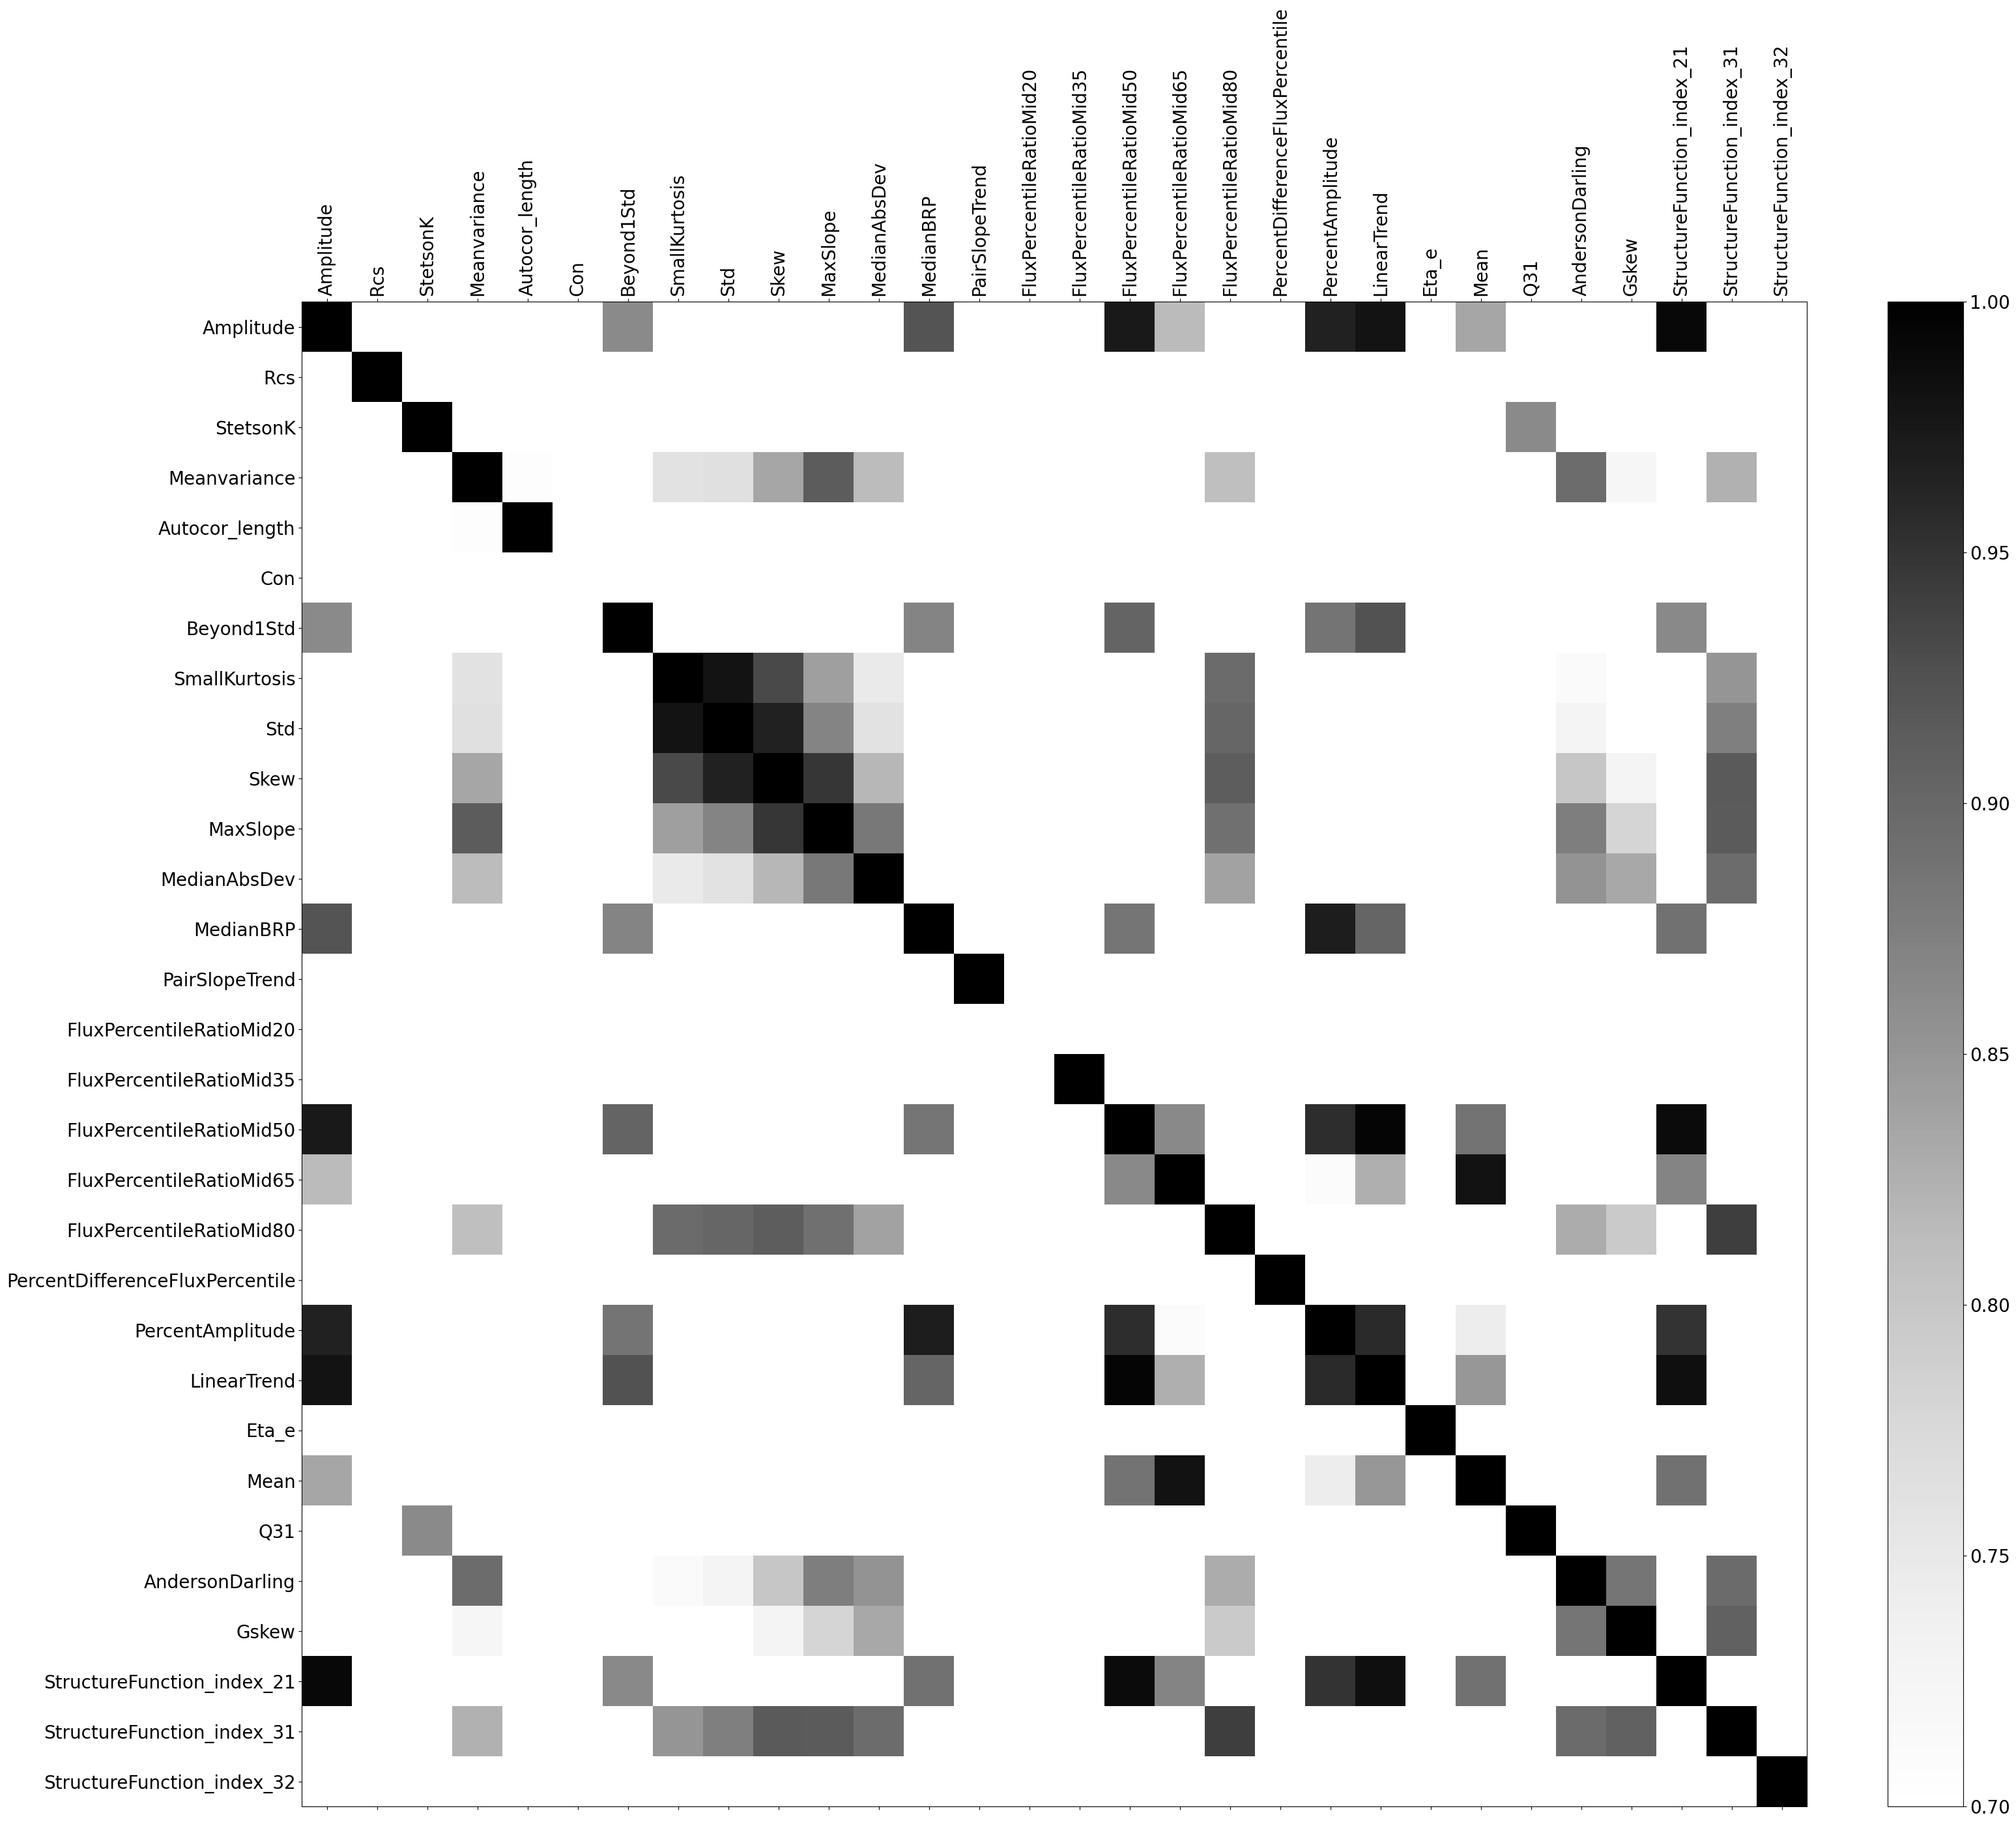

In [ ]:
fig= plt.figure(figsize=(19, 15))
ax = fig.add_subplot(111)
corr = df_clean.drop('Name', axis=1).corr()
cax = ax.matshow(abs(corr), cmap='Greys', vmin=0.7, vmax=1)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04).ax.tick_params(labelsize=20)

ax.tick_params(labelsize=20)
fig.set_size_inches(40, 30)

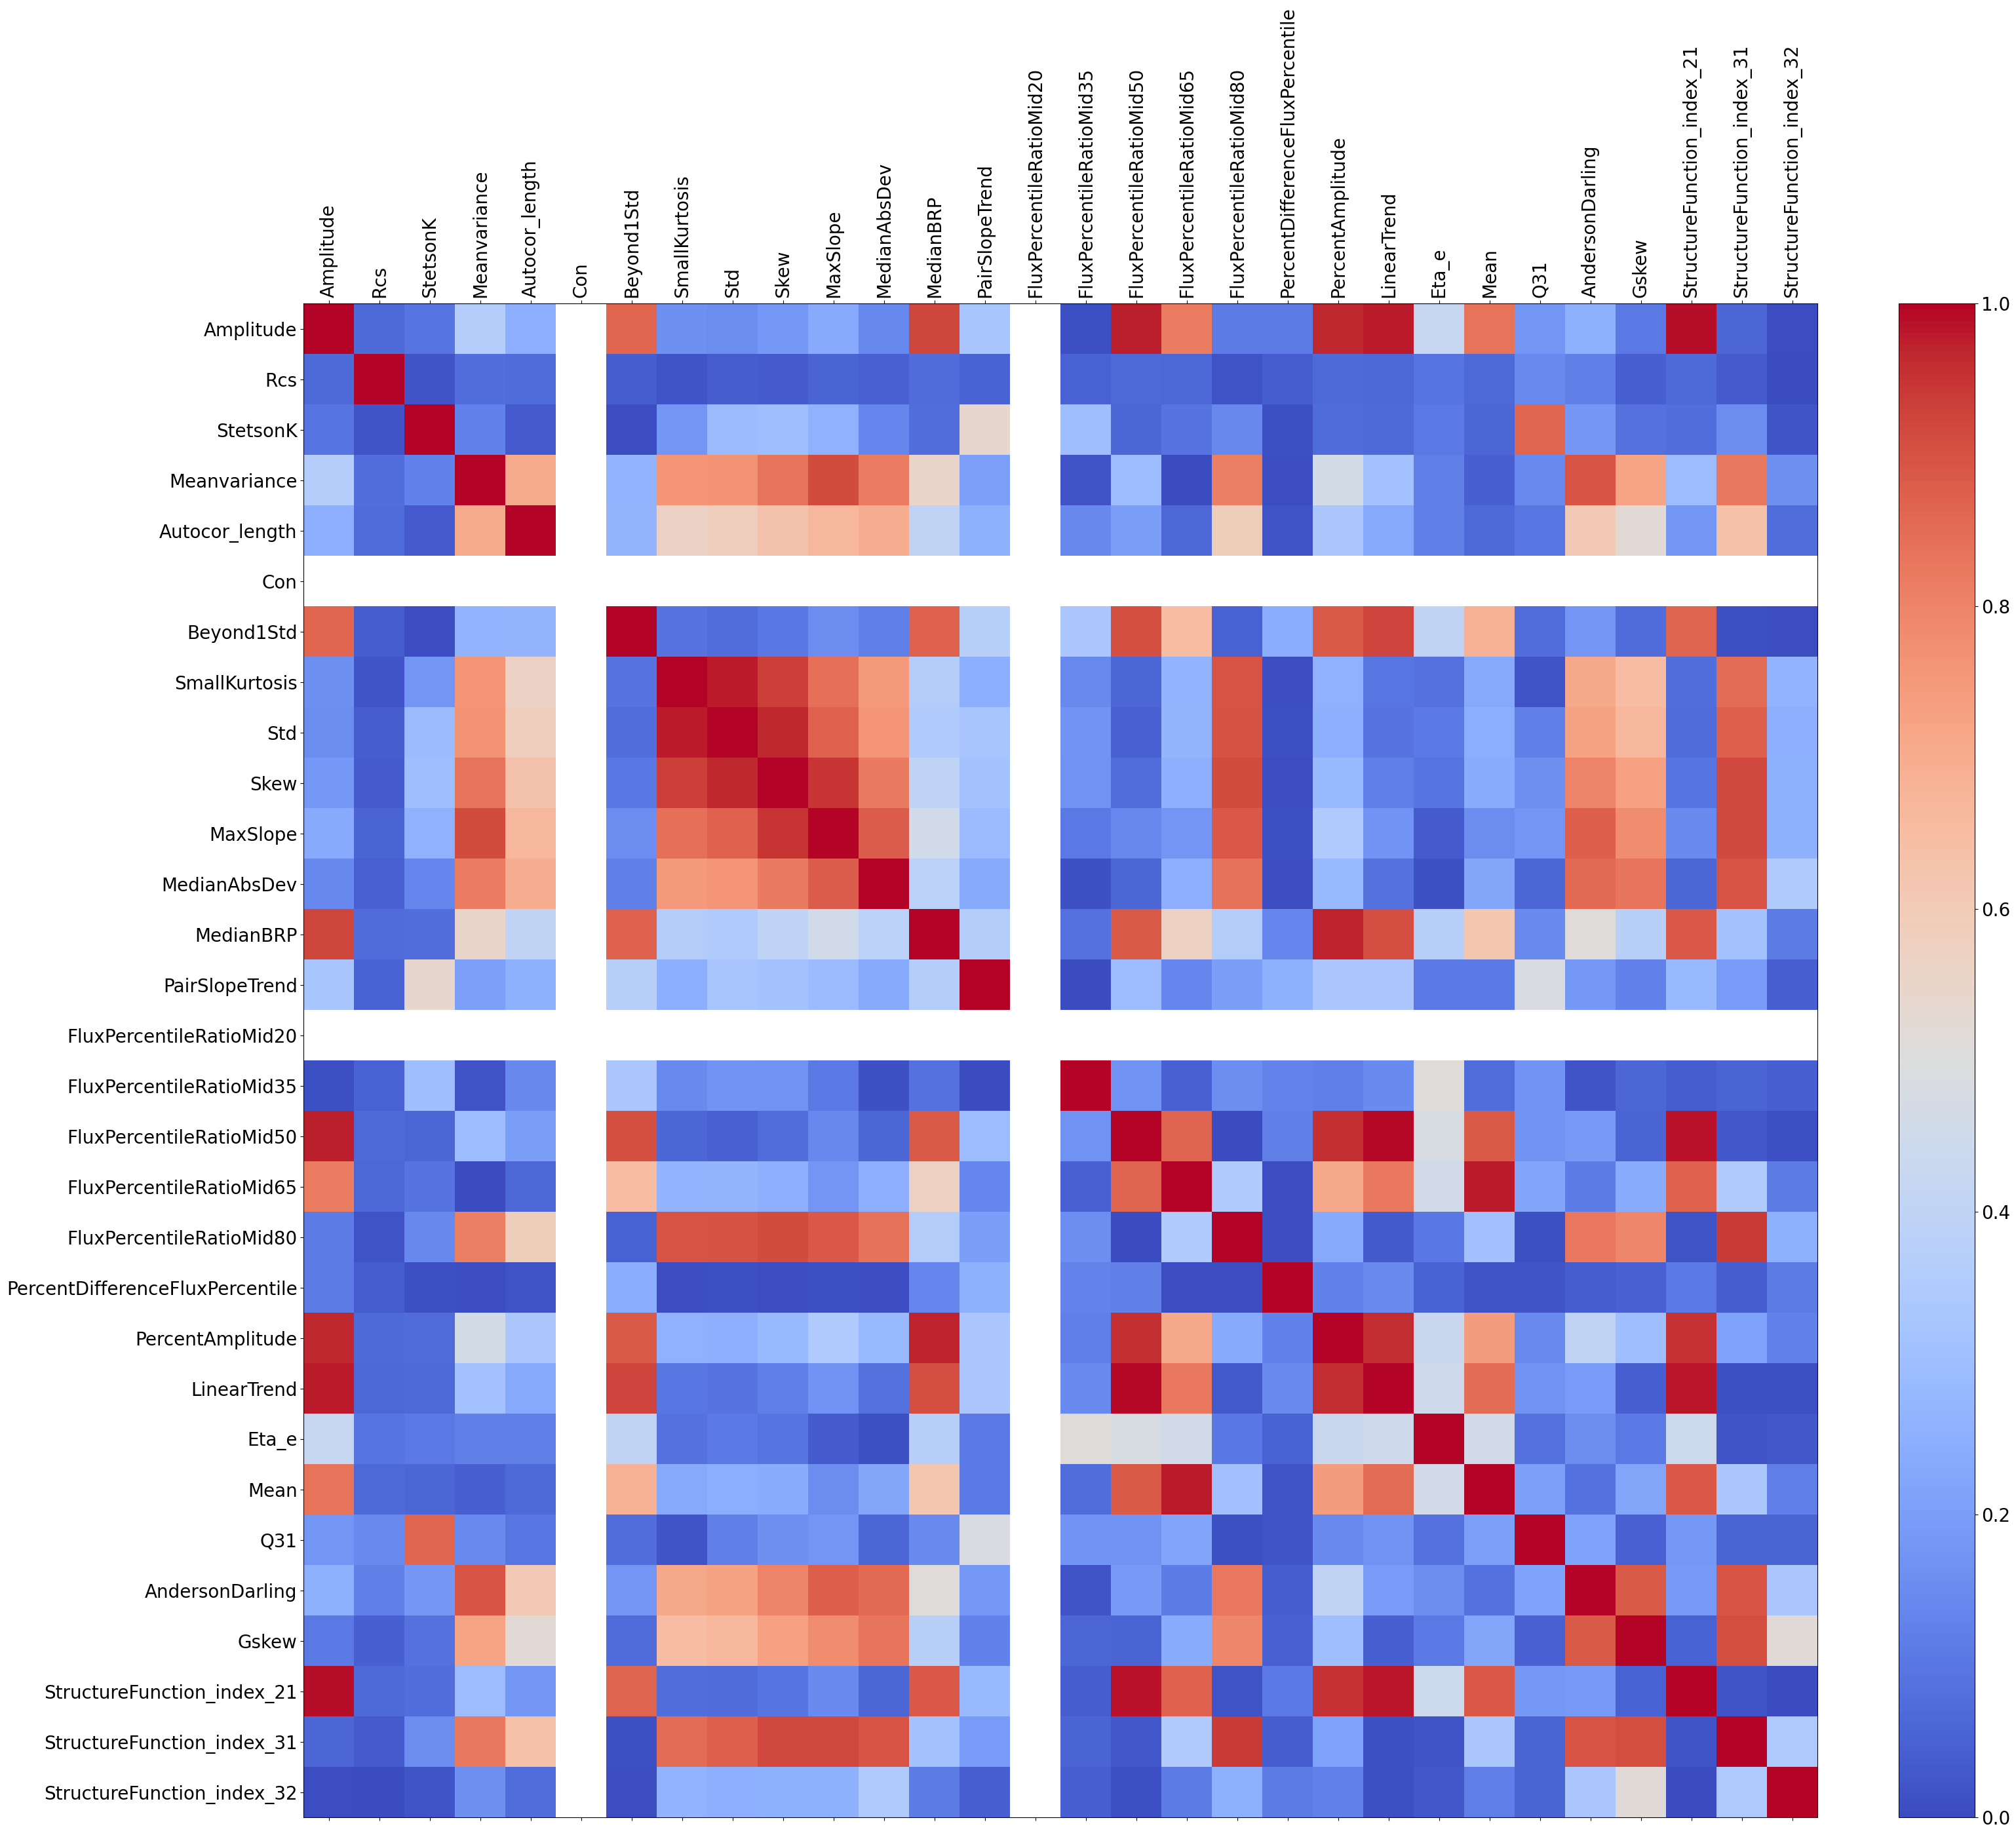

In [ ]:
fig= plt.figure(figsize=(19, 15))
ax = fig.add_subplot(111)
corr = df_clean.drop('Name', axis=1).corr()
cax = ax.matshow(abs(corr), cmap='coolwarm', vmin=0, vmax=1)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04).ax.tick_params(labelsize=20)

ax.tick_params(labelsize=20)
fig.set_size_inches(40, 30)

In [23]:
x_values=[]
for a in suffix_cleaned:
    with open(path + f'features/column_names_{a}.txt') as file:
        lines = file.read().splitlines()
        x_values.append([x for x in lines[0].split(',')])

columns = []

for xs in x_values:
    for x in xs:
        columns.append(x)
        
unique_cols = np.unique(columns)
df_col = pd.DataFrame({
    'feature': unique_cols,
    'count': [columns.count(a) for a in unique_cols]
})

df_col=df_col.sort_values('count', ascending=False, ignore_index=True)

corr_feats = list(df_col[:7]['feature'])
if 'StructureFunction_index_21' in corr_feats:
    corr_feats.remove('StructureFunction_index_21')
corr_feats

['Meanvariance',
 'Std',
 'StructureFunction_index_31',
 'PercentDifferenceFluxPercentile',
 'Amplitude',
 'Q31']

In [8]:
np.linspace(0, 24, 7)

array([ 0.,  4.,  8., 12., 16., 20., 24.])

/var/folders/_s/hyhjc88s5qz701qfpr83jgkw0000gp/T/ipykernel_13384/1920826558.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


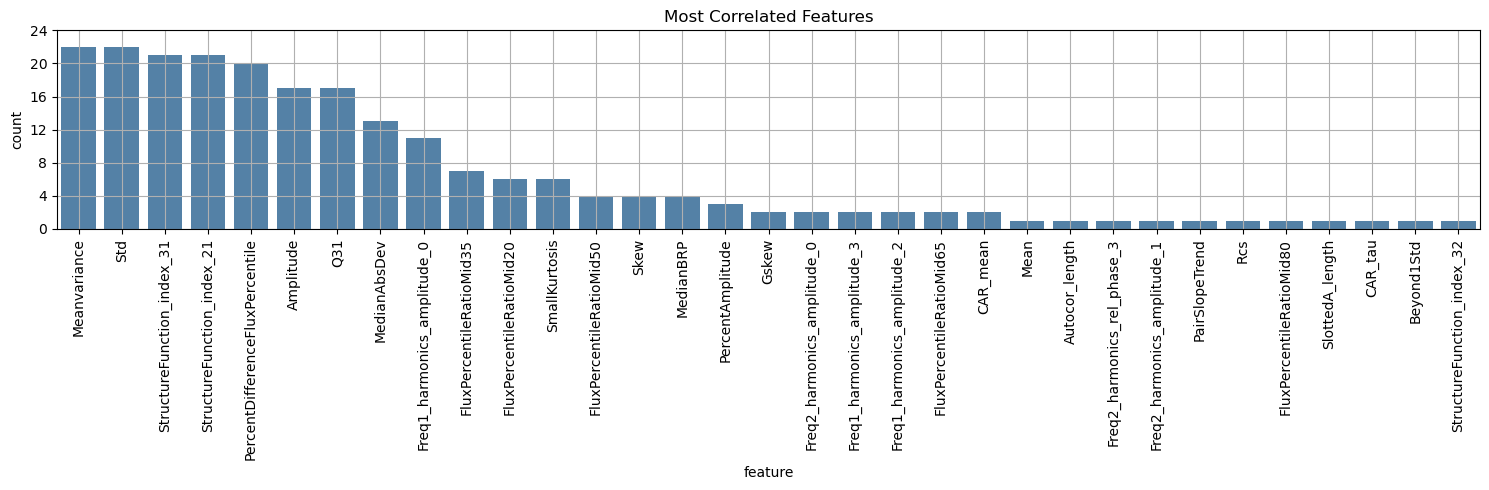

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_col, x='feature', y='count', color='steelblue', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.linspace(0, 24, 7))
ax.grid()
ax.set_title("Most Correlated Features")
fig.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/feets/extractors/ext_eta_e.py:115: RuntimeWarning: divide by zero encountered in divide
  w = 1.0 / np.power(np.subtract(time[1:], time[:-1]), 2)
/opt/anaconda3/lib/python3.11/site-packages/feets/extractors/ext_eta_e.py:124: RuntimeWarning: invalid value encountered in scalar divide
  eta_e = (w_mean * np.power(time[N - 1] -
/opt/anaconda3/lib/python3.11/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/opt/anaconda3/lib/python3.11/site-packages/feets/extractors/ext_eta_e.py:115: RuntimeWarning: divide by zero encountered in divide
  w = 1.0 / np.power(np.subtract(time[1:], time[:-1]), 2)
/opt/anaconda3/lib/python3.11/site-packages/feets/extractors/ext_eta_e.py:124: RuntimeWarning: invalid value encountered in scalar divide
  eta_e = (w_mean * np.power(time[N - 1] -
/opt/anaconda3/lib/python3.11/site-packages/feets

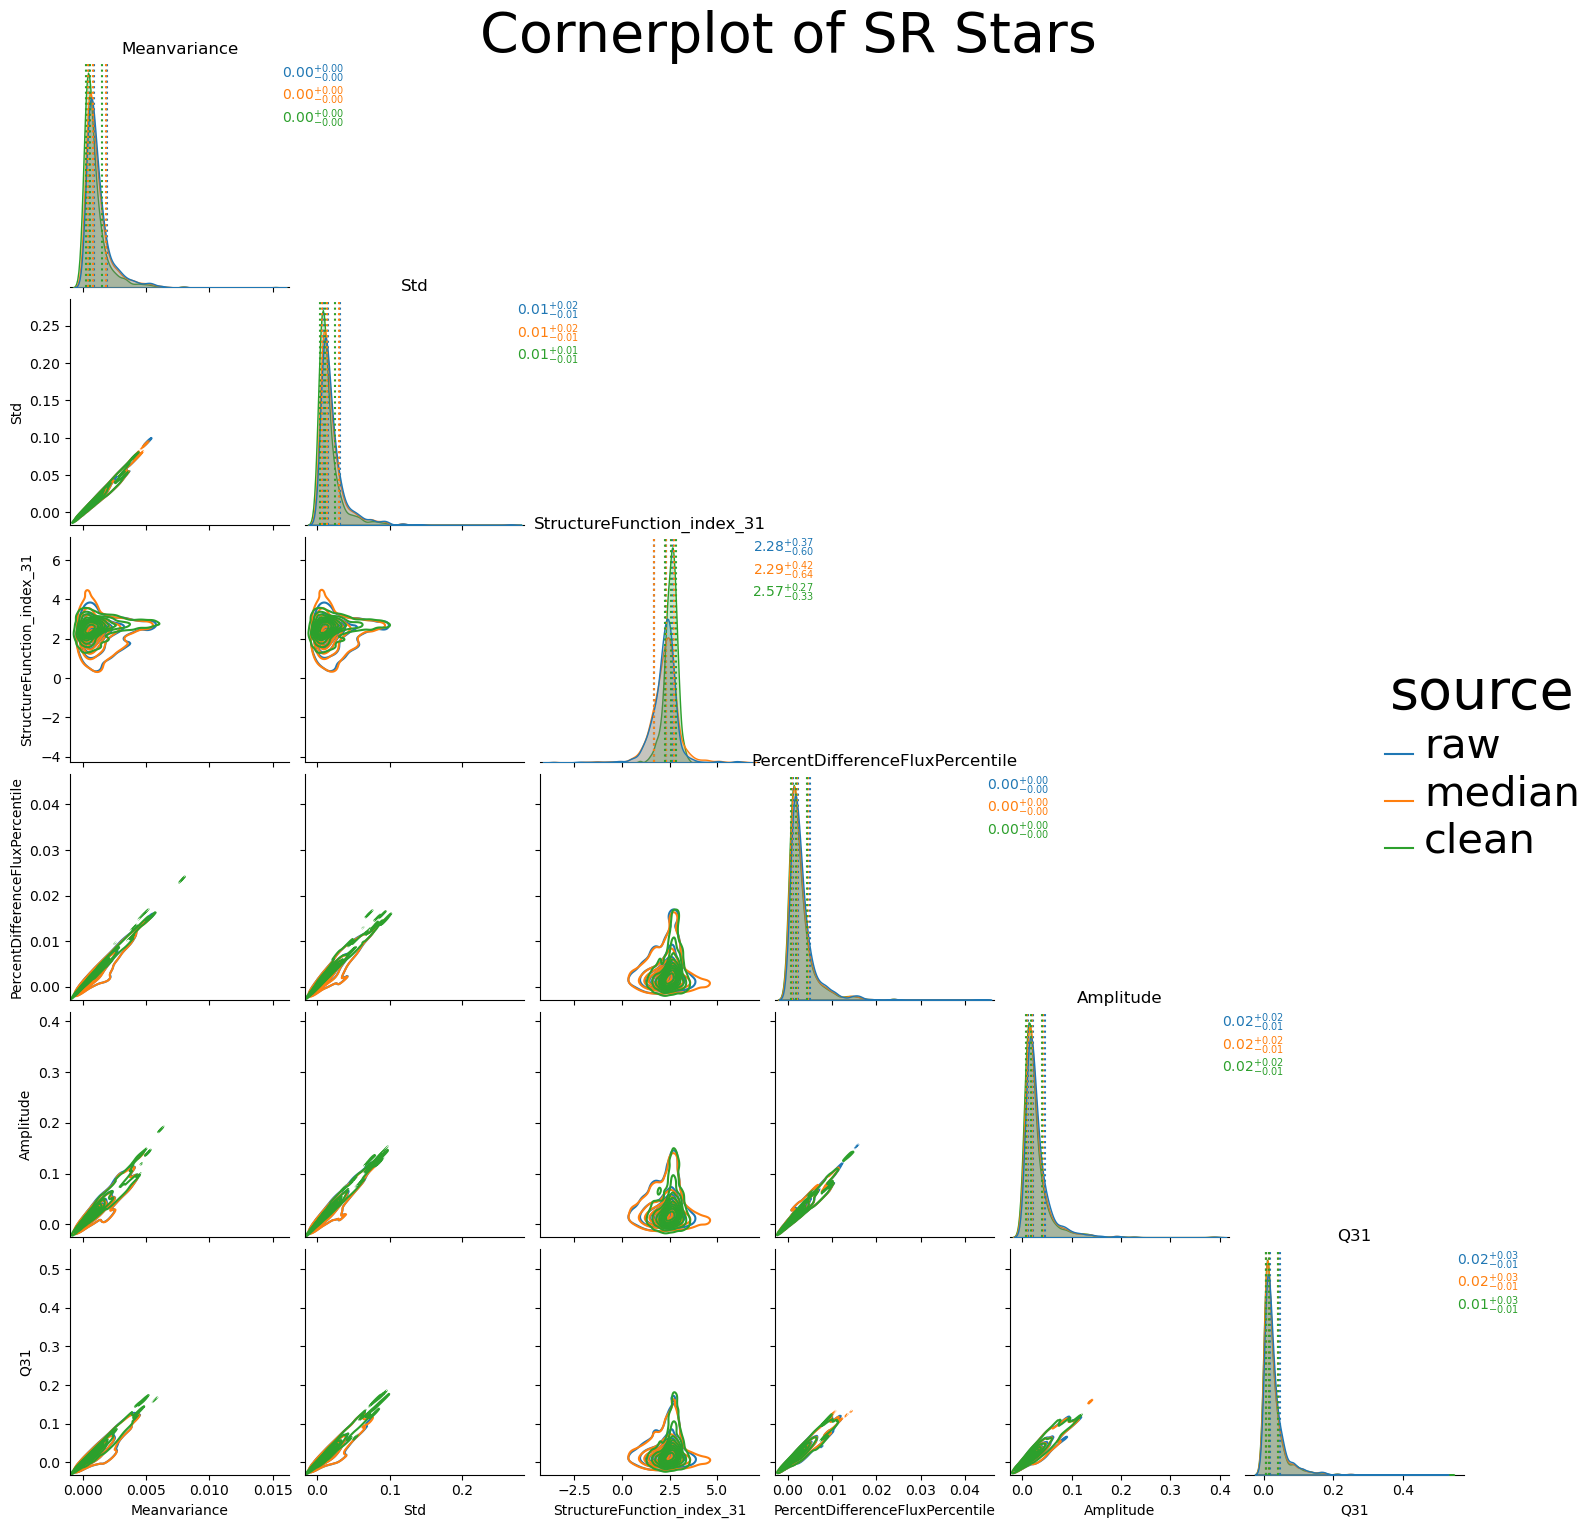

In [27]:
#for a in range(len(suffix_cleaned)):
#print(suffix_cleaned)
val = np.where(suffix_cleaned == f'{suffix_cleaned[-1]}')[0][0] 
#print(val)

pathfiles_median = Path(lc_median+suffix_median[val]) 
files_median=sorted([p.stem for p in pathfiles_median.rglob("*")])

pathfiles_raw = Path(lc_raw+suffix_raw[val])
files_raw=sorted([p.stem for p in pathfiles_raw.rglob("*")])

pathfiles_cleaned = Path(lc_cleaned+suffix_cleaned[val])
files_cleaned=sorted([p.stem for p in pathfiles_cleaned.rglob("*")])

for i in range(len(files_cleaned)):
    if '_cleaned' in files_cleaned[i]:
        files_cleaned[i] = files_cleaned[i].replace('_cleaned', '') 
common_files = [f for f in files_median if f in files_raw and f in files_cleaned]

del files_median, files_raw, files_cleaned
#------------------------------------------------------------
clean=paths_cleaned[val]
raw=paths_raw[val]
median=paths_median[val]

df_clean, df_raw, df_median = feats_features(clean, raw, median)
#corr_clean, corr_median, corr_raw = df_clean[corr_matrix(df_clean)], df_median[corr_matrix(df_clean)], df_raw[corr_matrix(df_clean)]

#with open(path + f"features/column_names_{suffix_cleaned[val]}.txt", "w") as f:
#    f.write(",".join(corr_clean.columns))
    
df_clean_tagged = df_clean[corr_feats].copy()
df_clean_tagged['source'] = 'clean'

df_raw_tagged = df_raw[corr_feats].copy()
df_raw_tagged['source'] = 'raw'

df_median_tagged = df_median[corr_feats].copy()
df_median_tagged['source'] = 'median'

combined_df = pd.concat([df_raw_tagged, df_median_tagged, df_clean_tagged], ignore_index=True)

ax = sns.pairplot(combined_df, hue='source', corner=True, kind='kde', diag_kind='kde')
ax.map_diag(diag_kde_with_title)
#ax.map_diag(diag_kde_contour)
ax.map_diag(update_diag_func)
plt.suptitle(f"Cornerplot of {suffix_cleaned[val]} Stars", y=1.02, fontsize='40')
plt.setp(ax._legend.get_texts(), fontsize='30')  #for legend text
plt.setp(ax._legend.get_title(), fontsize='40')  #for legend title

ax.savefig(path + f'figs_final/corner_{suffix_cleaned[val]}.pdf')
plt.show()

## Summary <a class="anchor" id="fifth-bullet"></a>

At this point, you should have:
* light curve plots that are meaningful: error bars, labels...
* a feature table for the outlier-cleaned light curve
* triangle plots that are meaningful: plot size/ number of types, colors, labels...